# Measure the radial velocity
This notebook uses the RVFitter class to do an MCMC fit. It looks up the spectral type on Simbad to estimate the temperature, and estimates the log(g) from the spectrum (you should have a Balmer line in there somewhere).

In [1]:
# Import a bunch of stuff
import StarData
import HelperFunctions
import Fitters
import Mamajek_Table
import SpectralTypeRelations
import matplotlib.pyplot as plt
import logging
import triangle
from astropy.io import fits
import numpy as np
import sys
import os

#%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Get the HDF5 filename. Might want to change this eventually.
home = os.environ['HOME']
hdf5_filename = '/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid_air.hdf5'

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# This function looks up the spectral type from simbad and uses the table from 
#  Pecaut & Mamajek to convert that into an effective temperature.

MT = Mamajek_Table.MamajekTable()
MS = SpectralTypeRelations.MainSequence()
sptnum2teff = MT.get_interpolator('SpTNum', 'Teff') 

def make_fitter(fname, Teff=None, logg=4.0, feh=0.0, first_order=3, last_order=19):
    orders = HelperFunctions.ReadExtensionFits(fname)
    
    if Teff is None:
        header = fits.getheader(fname)
        starname = header['OBJECT']
        SpT = StarData.GetData(starname).spectype
        Teff = sptnum2teff(MS.SpT_To_Number(SpT))

    # make sure Teff is in the grid
    hdf5_int = Fitters.StellarModel.HDF5Interface(hdf5_filename)
    grid_teffs = np.unique([d['temp'] for d in hdf5_int.list_grid_points])
    if Teff > max(grid_teffs):
        Teff = max(grid_teffs)
    #idx = np.argmin((grid_teffs - Teff)**2)
    #Teff = grid_teffs[idx]
    print(Teff)


    print(hdf5_filename)
    fitter = Fitters.RVFitter(orders[first_order:last_order+1], model_library=hdf5_filename, 
                              T=Teff, logg=logg, feh=feh, norm_model=False)
    return fitter

In [8]:
# Use the fitter to flatten the spectrum
#fitter = make_fitter('Adam_Data/20140210/HIP_56561.fits', logg=4.0, first_order=3, last_order=19)
reload(Fitters)
fitter = make_fitter('../20150113/HIP_24505.fits', logg=4.0, first_order=3, last_order=19)
pars = fitter.guess_fit_parameters(vsini_trials=20, refine=True, N=10)

10700.0
/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid.hdf5
Determine Chunk Log: Wl is 65536

INFO:root:Estimating the RV and vsini by cross-correlation
INFO:root:Estimating logg and Teff by brute force. Get some coffee...
INFO:root:T = 9200.0
logg = 3.0
INFO:root:T = 9200.0
logg = 3.0
INFO:root:T = 9200.0
logg = 3.16666666667
INFO:root:T = 9200.0
logg = 3.33333333333
INFO:root:T = 9200.0
logg = 3.5
INFO:root:T = 9200.0
logg = 3.66666666667
INFO:root:T = 9200.0
logg = 3.83333333333
INFO:root:T = 9200.0
logg = 4.0
INFO:root:T = 9200.0
logg = 4.16666666667
INFO:root:T = 9200.0
logg = 4.33333333333
INFO:root:T = 9200.0
logg = 4.5
INFO:root:T = 9533.33333333
logg = 3.0
INFO:root:T = 9533.33333333
logg = 3.16666666667
INFO:root:T = 9533.33333333
logg = 3.33333333333
INFO:root:T = 9533.33333333
logg = 3.5
INFO:root:T = 9533.33333333
logg = 3.66666666667
INFO:root:T = 9533.33333333
logg = 3.83333333333
INFO:root:T = 9533.33333333
logg = 4.0
INFO:root:T = 9533.33333333
logg = 4.16666666667
INFO:root:T = 9533.33333333
logg = 4.33333333333
INFO:root:T = 9533.33333333
logg = 4.5
INFO:root

[array([ 41.65760717]), 212.29096215204206, 0.5, 10533.333333333334, 10533.333333333334]
(10533.333333333334, 3.7112763454726463)


<IPython.core.display.Javascript object>


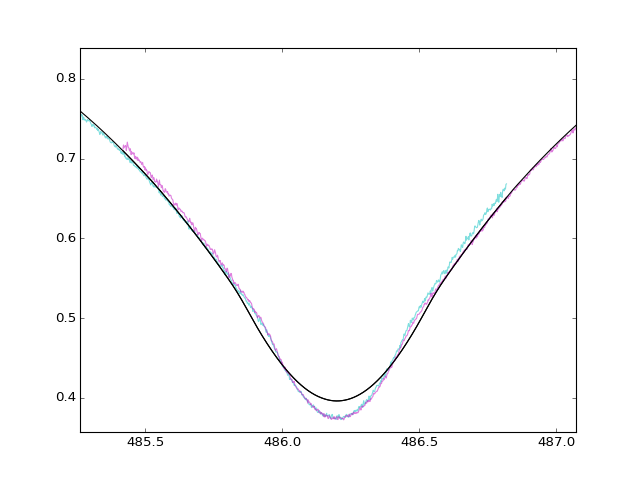

In [9]:
print(pars)
print(fitter._T, fitter._logg)
%matplotlib notebook
flattened_orders = fitter.flatten_spectrum(plot=True, pars=pars)

In [16]:
def remake_fitter(filename, model_library, teff, logg, feh=0.0, output_basename='../RVFitter_flattened'):
    print(filename, teff, logg)
    # Read in the (assumed flattened) spectra
    all_orders = HelperFunctions.ReadExtensionFits(filename)
    
    orders = [o.copy() for o in all_orders if o.x[0] < 475 or o.x[-1] > 495]
    #orders = all_orders
    # Set up the fitter
    fitter = Fitters.RVFitter(orders, model_library=model_library,
                              T=teff, logg=logg, feh=feh)
    header = fits.getheader(filename)
    starname = header['OBJECT']
    date = header['DATE-OBS'].split('T')[0]
    stardata_str = '{}_{}-'.format(starname.replace(' ', ''), date.replace('-', ''))
    basename = os.path.join(output_basename, stardata_str)

    # Fit
    fitter.fit(backend='multinest', n_live_points=1000, basename=basename, overwrite=True, init_MPI=False)
    
    return fitter


In [3]:
import pandas as pd
df = pd.read_csv('../Flatten.log', header=None, names=['fname', 'star', 'date', 'teff', 'logg', 'rv_guess'])
df.head()

,fname,star,date,teff,logg,rv_guess
0,20140514/HIP_85537.fits,HIP 85537,2014-05-15,7364.229691,3.330221,46.462539
1,20140804/HIP_79007.fits,HIP 79007,2014-08-04,7691.750679,3.766727,-26.690580
2,20140804/HIP_2381.fits,HIP 2381,2014-08-05,8448.354758,3.393724,8.241084
3,20130206/HIP_41039.fits,HIP 41039,2013-02-07,26000.000000,4.000000,100.000000
4,20150321/HIP_85922.fits,HIP 85922,2015-03-22,7866.455266,4.476049,45.578677


In [4]:
df.loc[df.star == 'HIP 5348']

,fname,star,date,teff,logg,rv_guess
76,20130201/HIP_5348.fits,HIP 5348,2013-02-02,14562.910989,4.002023,62.801248


In [17]:
idx = 76
print df.loc[idx, 'fname']
fname = '../{}'.format(df.loc[idx, 'fname'].replace('.fits', '_renormalized.fits'))
teff = df.loc[idx, 'teff']
logg = df.loc[idx, 'logg']
fitter = remake_fitter(fname, hdf5_filename, teff, logg, output_basename='../RVFitter_nobalmer/')

20130201/HIP_5348.fits
('../20130201/HIP_5348_renormalized.fits', 14562.910989399999, 4.0020229178900006)
Determine Chunk Log: Wl is 131072

/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1630: UserWarning: vsini too small (53987.5030518). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1630: UserWarning: vsini too small (49350.2616882). Not broadening!
  linear=True, findcont=False)


/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1630: UserWarning: vsini too small (19929.4090271). Not broadening!
  linear=True, findcont=False)


In [18]:
#%matplotlib inline
fitter.triangle()
plt.show()

In [20]:
#%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(10,8))
fitter.plot(ax=ax, N=10)
#plt.ylim((-0.1, 1.5))
plt.show()

In [19]:
for x, y in zip(fitter.x, fitter.y):
    plt.plot(x, y)
plt.show()

In [5]:
y = fitter.interpolator(dict(temp=7345, logg=3.3, Z=0.0))
x = fitter.interpolator.wl
plt.plot(x, y)
plt.ylim((0, 100000))
plt.show()

10700.0
/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid.hdf5
Determine Chunk Log: Wl is 65536


<IPython.core.display.Javascript object>


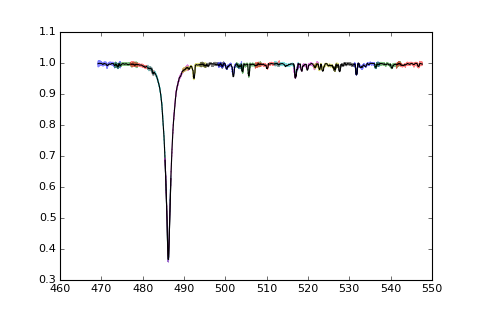

In [26]:
reload(Fitters)
fitter = make_fitter('20150113/HIP_24505.fits', logg=4.0, first_order=3, last_order=19)
fitter.update_model(Teff=10717.241379310344, logg=3.97)
%matplotlib notebook
flattened_orders2 = fitter.flatten_spectrum(plot=True, update_logg=False, update_teff_logg=False, fitorder=3,
                                           pars=[43.706964760864579, 153.68421052631578, 0.5, 3500, 10717.241379310344])

In [30]:
import glob
star_list = [f for f in glob.glob('../201*/H*.fits') if 'smoothed' not in f and 'uncorrected' not in f and 'flattened' not in f]
print(len(star_list))
star_list.index('../20140517/HIP_118121.fits')

215


113

<IPython.core.display.Javascript object>


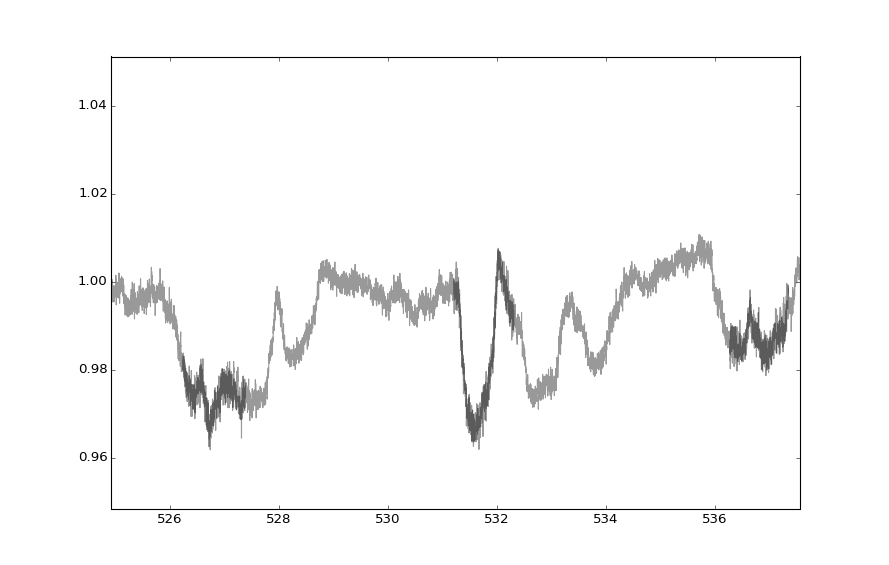

In [29]:
flattened_orders = HelperFunctions.ReadExtensionFits('../20140517/HIP_118121_flattened.fits')
%matplotlib notebook
for order in flattened_orders:
    plt.plot(order.x, order.y, 'k-', alpha=0.4)

In [16]:
# Fit the RV to the flattened spectrum
flat_fitter = Fitters.RVFitter(flattened_orders, model_library=hdf5_filename, 
                               T=7364.2, logg=3.330, feh=0.0)
flat_fitter.fit(backend='multinest', n_live_points=1000, basename='RVFitter/HIP85537_20140514-', overwrite=False)

/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1629: UserWarning: vsini too small (13823.5092163). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1629: UserWarning: vsini too small (63731.6703796). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1629: UserWarning: vsini too small (16078.9489746). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1629: UserWarning: vsini too small (9958.74404907). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1629: UserWarning: vsini too small (7529.25872803). Not broadening!
  linear=True, findcont=False)
/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1629: UserWarning: vsini too small (64713.9549255). Not broadening!
  linear=True, findcont=False)


Determine Chunk Log: Wl is 131072


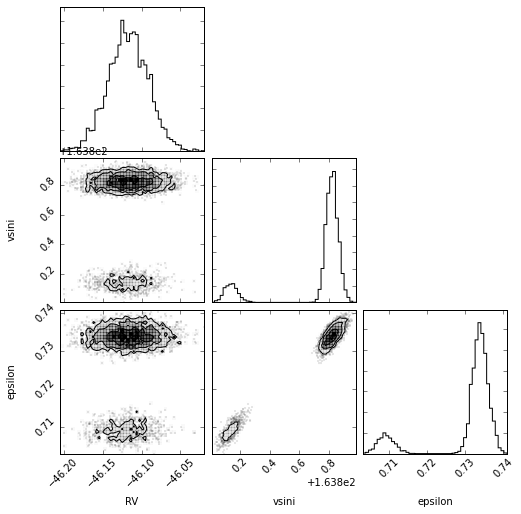

In [17]:
%matplotlib inline
flat_fitter.triangle()

In [18]:
flat_fitter.samples.describe()

,RV,epsilon,lnprob,vsini
count,4784.000000,4784.000000,4784.000000,4784.000000
mean,-46.117030,0.730559,-2936367.529780,164.525524
std,0.025843,0.008880,1.424378,0.239661
min,-46.204264,0.703086,-2936375.868919,163.809697
25%,-46.134300,0.731725,-2936368.342198,164.576135
50%,-46.117008,0.733609,-2936367.144030,164.611340
75%,-46.099324,0.735120,-2936366.416767,164.641771
max,-46.019153,0.741001,-2936365.709551,164.778557


<IPython.core.display.Javascript object>


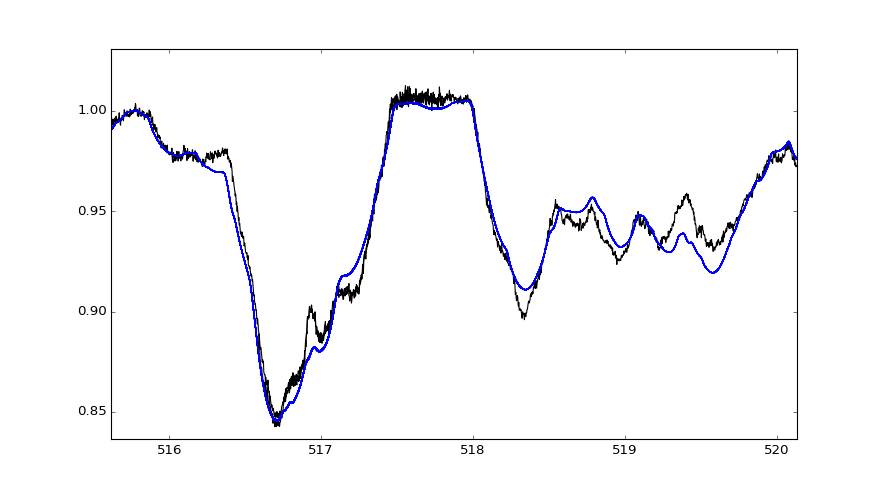

In [19]:
%matplotlib notebook
flat_fitter.plot()

# Does the emcee backend work?

In [17]:
emcee_fitter = Fitters.RVFitter(flattened_orders, model_library=hdf5_filename, 
                               T=fitter._T, logg=fitter._logg, feh=fitter._feh)
emcee_fitter.fit(backend='emcee', n_burn=100, n_prod=300, guess=False, initial_pars=[20.34, 160.70, 0.761])

Determine Chunk Log: Wl is 65536
Running burn-in

INFO:root:Done with burn-in iteration 1 / 100
INFO:root:Done with burn-in iteration 11 / 100
INFO:root:Done with burn-in iteration 21 / 100
INFO:root:Done with burn-in iteration 31 / 100
INFO:root:Done with burn-in iteration 41 / 100
INFO:root:Done with burn-in iteration 51 / 100
INFO:root:Done with burn-in iteration 61 / 100
INFO:root:Done with burn-in iteration 71 / 100
INFO:root:Done with burn-in iteration 81 / 100
INFO:root:Done with burn-in iteration 91 / 100



Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1

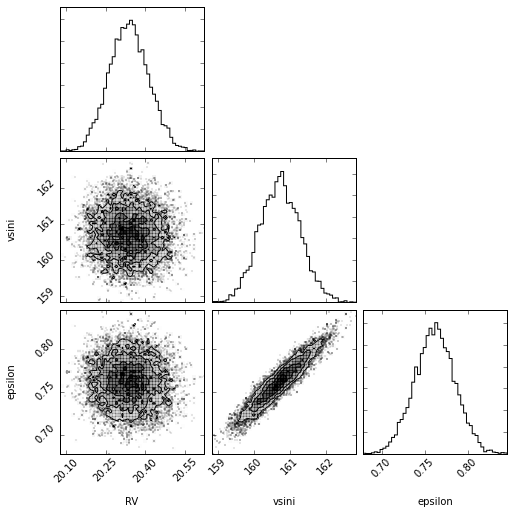

In [33]:
%matplotlib inline
emcee_fitter.triangle()

<IPython.core.display.Javascript object>


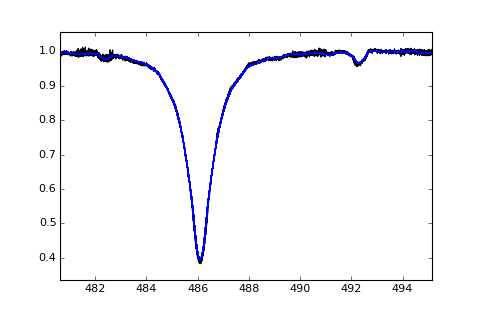

In [36]:
%matplotlib notebook
emcee_fitter.plot()

In [35]:
emcee_fitter.samples.describe()

,RV,epsilon,lnprob,vsini
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,20.337661,0.761739,210525.194550,160.727468
std,0.074593,0.023367,1.174809,0.563943
min,20.078375,0.678068,210516.721452,158.825016
25%,20.286839,0.746070,210524.625132,160.338103
50%,20.336594,0.761894,210525.482334,160.724248
75%,20.387914,0.777517,210526.070139,161.110036
max,20.622756,0.845453,210526.653922,162.826189


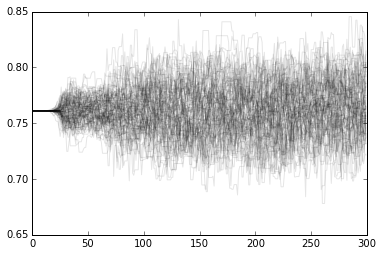

In [24]:
_ = plt.plot(emcee_fitter.sampler.chain[:, :, 2].T, 'k-', alpha=0.1)

In [32]:
ndim = 3
samples = emcee_fitter.sampler.chain[:, 100:, :].reshape((-1, ndim))
lnprob = emcee_fitter.sampler.lnprobability[:, 100:].flatten()
chain_dict = {emcee_fitter.param_names[i]: samples[:, i] for i in range(emcee_fitter.n_params)}
chain_dict['lnprob'] = lnprob

import pandas as pd
emcee_fitter.samples = pd.DataFrame(data=chain_dict)

In [30]:
emcee_fitter.sampler.lnprobability[:, 100:].flatten().shape

(20000,)